# 尝试微调 LLM：让它会写唐诗
> [GenAI HW5: LLM Fine-tuning](https://colab.research.google.com/drive/1nB3jwRJVKXSDDNO-pbURrao0N2MpqHl8?usp=sharing#scrollTo=uh5rwbr4q5Nw) 中文镜像版
>
> 指导文章：[08. 尝试微调 LLM：让它会写唐诗](https://github.com/Hoper-J/LLM-Guide-and-Demos-zh_CN/blob/master/Guide/08.%20尝试微调%20LLM：让它会写唐诗.md)

在此作业中，你将微调自己的 LLM，使其能够写唐诗。有关详细信息，请参阅 [作业PDF](https://github.com/Hoper-J/LLM-Guide-and-Demos-zh_CN/blob/master/GenAI_PDF/HW5.pdf)

**TODOs**
1. 阅读幻灯片并确保你理解了作业的目标。
2. 按照此笔记本中的步骤微调你的 LLM。

在这里你不需要去从 0 开始写你的微调代码，所有的函数主体都已经给出。

## 使用 GPU
- 点击标题中的“Runtime”（或“代码执行程序”）。
- 在下拉菜单中点击“Change runtime type”（或“更改运行时类型”）。
- 选择“T4 GPU”并保存。（如果你有Colab Pro，可以选择“A100 GPU”或“V100 GPU”）

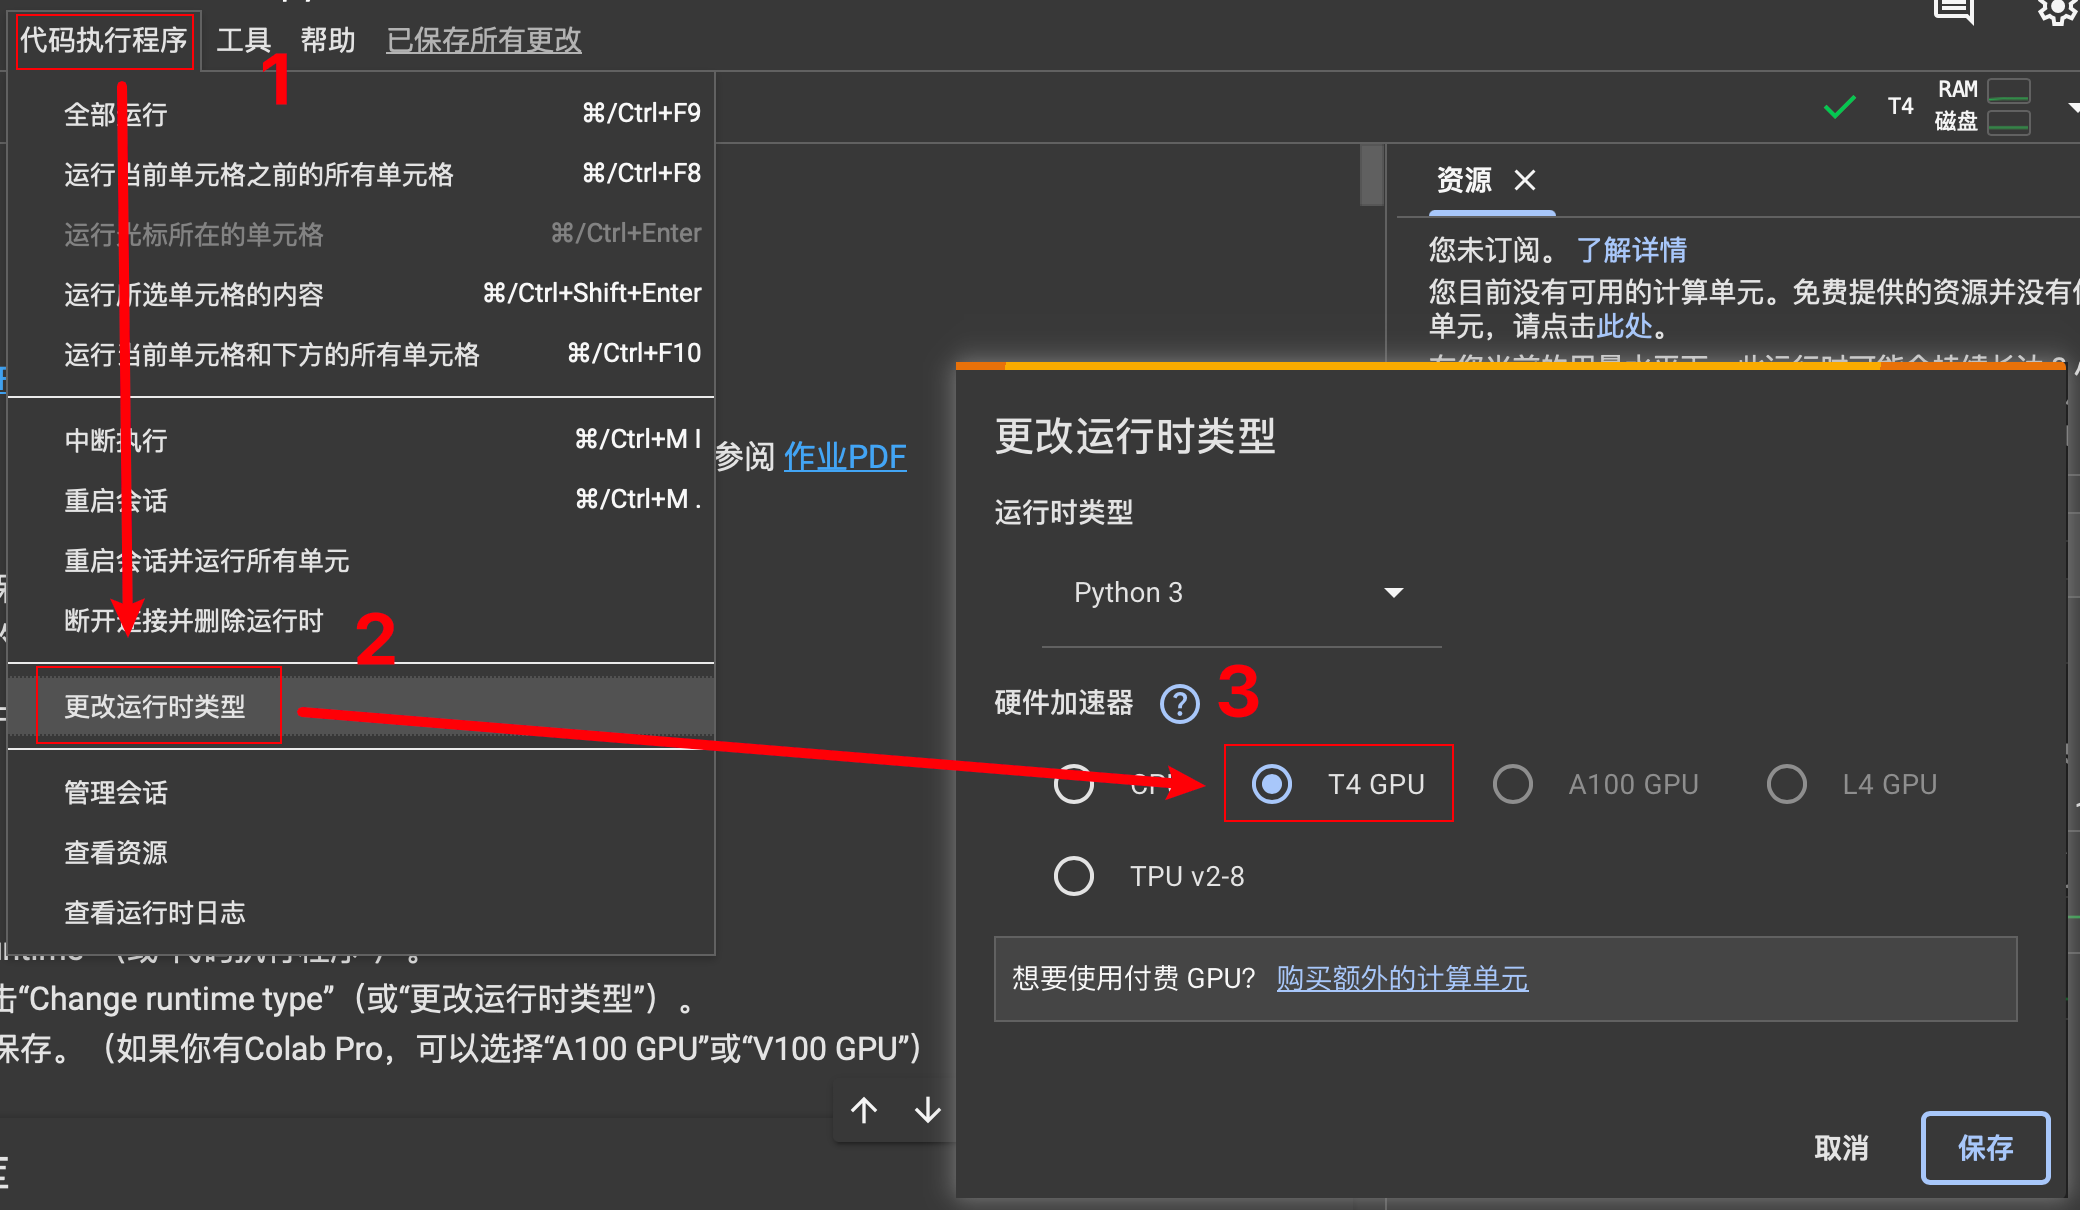

## 安装必要的库
我们安装并导入一些由其他人编写的优秀库，以便简化微调过程。


In [1]:
!pip install bitsandbytes==0.43.0
!pip install datasets==2.10.1
!pip install transformers==4.38.2
!pip install peft==0.9.0
!pip install sentencepiece==0.1.99
!pip install -U accelerate==0.28.0
!pip install colorama==0.4.6
!pip install fsspec==2023.9.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 6.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 40.2 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.0
    Uninstalling tokenizers-0.21.0:
      Successfully uninstalled tokenizers-0.21.0
  Attempting uninstall: transformers
   

In [2]:
import os
import sys
import argparse
import json
import warnings
import logging
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import bitsandbytes as bnb
from datasets import load_dataset, load_from_disk
import transformers
from peft import PeftModel
from colorama import Fore, Style

from tqdm import tqdm
from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    GenerationConfig
)
from peft import (
    prepare_model_for_int8_training,
    LoraConfig,
    get_peft_model,
    get_peft_model_state_dict,
    prepare_model_for_kbit_training
)


## 下载用于微调的数据集

In [5]:
!git clone https://github.com/CheeEn-Yu/GenAI-Hw5.git

Cloning into 'GenAI-Hw5'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 38 (delta 15), reused 26 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (38/38), 3.68 MiB | 15.19 MiB/s, done.
Resolving deltas: 100% (15/15), done.


## 固定随机种子
为了使微调结果可重复，我们固定随机种子。

In [3]:
seed = 42
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

## 定义一些有用的函数

In [6]:
# 生成训练数据
def generate_training_data(data_point):
    """
    将输入和输出文本转换为模型可读取的 tokens。

    参数：
    - data_point: 包含 "instruction"、"input" 和 "output" 字段的字典。

    返回：
    - 包含模型输入 IDs、标签和注意力掩码的字典。

    示例:
    - 如果你构建了一个字典 data_point_1，并包含字段 "instruction"、"input" 和 "output"，你可以像这样使用函数：
        generate_training_data(data_point_1)
    """
    # 构建完整的输入提示词
    prompt = f"""\
[INST] <<SYS>>
You are a helpful assistant and good at writing Tang poem. 你是一個樂於助人的助手且擅長寫唐詩。
<</SYS>>

{data_point["instruction"]}
{data_point["input"]}
[/INST]"""

    # 计算用户提示词的 token 数量
    len_user_prompt_tokens = (
        len(
            tokenizer(
                prompt,
                truncation=True,
                max_length=CUTOFF_LEN + 1,
                padding="max_length",
            )["input_ids"]
        ) - 1
    )

    # 将完整的输入和输出转换为 tokens
    full_tokens = tokenizer(
        prompt + " " + data_point["output"] + "</s>",
        truncation=True,
        max_length=CUTOFF_LEN + 1,
        padding="max_length",
    )["input_ids"][:-1]
# 构建 labels，对于提示词部分的 tokens，使用 -100（在计算损失时会被忽略），对于输出部分的 tokens，保留实际的 token ID。
    return {
        "input_ids": full_tokens,
        "labels": [-100] * len_user_prompt_tokens + full_tokens[len_user_prompt_tokens:],
        "attention_mask": [1] * len(full_tokens),
    }

# 评估模型生成的回复
def evaluate(instruction, generation_config, max_len, input_text="", verbose=True):
    """
    获取模型在给定输入下的生成结果。

    参数：
    - instruction: 描述任务的字符串。
    - generation_config: 模型生成配置。
    - max_len: 最大生成长度。
    - input_text: 输入文本，默认为空字符串。
    - verbose: 是否打印生成结果。

    返回：
    - output: 模型生成的文本。
    """
    # 构建完整的输入提示词
    prompt = f"""\
[INST] <<SYS>>
You are a helpful assistant and good at writing Tang poem. 你是一個樂於助人的助手且擅長寫唐詩。
<</SYS>>

{instruction}
{input_text}
[/INST]"""

    # 将提示词转换为模型所需的 token 格式
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"].cuda()

    # 使用模型生成回复
    generation_output = model.generate(
        input_ids=input_ids,
        generation_config=generation_config,
        return_dict_in_generate=True,
        output_scores=True,
        max_new_tokens=max_len,
    )

    # 解码并打印生成的回复
    for s in generation_output.sequences:
        output = tokenizer.decode(s)
        output = output.split("[/INST]")[1].replace("</s>", "").replace("<s>", "").replace("Assistant:", "").replace("Assistant", "").strip()
        if verbose:
            print(output)

    return output

## 下载模型并在微调前进行推理

In [7]:
""" 你可以（但不一定需要）更改 LLM 模型 """

model_name = "MediaTek-Research/Breeze-7B-Instruct-v0_1"  # 默认选择 MediaTek Breeze 7B 模型


### 微调前的推理
让我们先看看在未进行微调的情况下，模型的表现如何。

#### 加载模型
注意，下面这段代码会占用大概 5.*G 的显存

In [8]:
""" 建议不要更改此单元格中的代码 """

cache_dir = "./cache"

nf4_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=torch.bfloat16
)

# 从指定模型名称或路径加载预训练语言模型
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    cache_dir=cache_dir,
    quantization_config=nf4_config,
    low_cpu_mem_usage=True
)

# 创建 tokenizer 并设置结束符号 (eos_token)
logging.getLogger('transformers').setLevel(logging.ERROR)
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    add_eos_token=True,
    cache_dir=cache_dir,
    quantization_config=nf4_config
)
tokenizer.pad_token = tokenizer.eos_token

# 设置模型推理时的解码参数
max_len = 128
generation_config = GenerationConfig(
    do_sample=True,
    temperature=0.1,
    num_beams=1,
    top_p=0.3,
    no_repeat_ngram_size=3,
    pad_token_id=2,
)

config.json:   0%|          | 0.00/618 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/911k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.79M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

#### 初始表现

In [9]:
""" 建议不要更改此单元格中的代码，样例和Prompt都保持繁体 """

# 测试样例
test_tang_list = [
    '相見時難別亦難，東風無力百花殘。',
    '重帷深下莫愁堂，臥後清宵細細長。',
    '芳辰追逸趣，禁苑信多奇。'
]

# 获取每个样例的模型输出
demo_before_finetune = []
for tang in test_tang_list:
    demo_before_finetune.append(
        f'模型輸入:\n以下是一首唐詩的第一句話，請用你的知識判斷並完成整首詩。{tang}\n\n模型輸出:\n' +
        evaluate('以下是一首唐詩的第一句話，請用你的知識判斷並完成整首詩。', generation_config, max_len, tang, verbose=False)
    )

# 打印并将输出存储到文本文件
for idx in range(len(demo_before_finetune)):
    print(f"Example {idx + 1}:")
    print(demo_before_finetune[idx])
    print("-" * 80)

Example 1:
模型輸入:
以下是一首唐詩的第一句話，請用你的知識判斷並完成整首詩。相見時難別亦難，東風無力百花殘。

模型輸出:
相望時難分亦難別，東風吹拂百花欲殘殘。
--------------------------------------------------------------------------------
Example 2:
模型輸入:
以下是一首唐詩的第一句話，請用你的知識判斷並完成整首詩。重帷深下莫愁堂，臥後清宵細細長。

模型輸出:
重帷下，重帷之下，深下，莫愁之堂。
--------------------------------------------------------------------------------
Example 3:
模型輸入:
以下是一首唐詩的第一句話，請用你的知識判斷並完成整首詩。芳辰追逸趣，禁苑信多奇。

模型輸出:
芳辰逐逸趣、禁苑寄多奇，春色似水月，花影如風姿。
--------------------------------------------------------------------------------


可以发现这并没有完成补充唐诗的任务，而是对内容进行重复（除了最后一个example）

## 设置用于微调的超参数

In [11]:
""" 强烈建议你尝试调整这个参数 """

num_train_data = 1080  # 设置用于训练的数据量，最大值为5000。通常，训练数据越多越好，模型会见到更多样化的诗句，从而提高生成质量，但也会增加训练时间。
                      # 使用默认参数(1040)：微调大约需要25分钟，完整运行所有单元大约需要50分钟。
                      # 使用最大值(5000)：微调大约需要100分钟，完整运行所有单元大约需要120分钟。

In [12]:
""" 你可以（但不一定需要）更改这些超参数 """

output_dir = "./output"  # 设置作业结果输出目录。
ckpt_dir = "./exp1"  # 设置 model checkpoint 保存目录（如果想将 model checkpoints 保存到其他目录下，可以修改这里）。
num_epoch = 1  # 设置训练的总 Epoch 数（数值越高，训练时间越长，若使用免费版的 Colab 需要注意时间太长可能会断线，本地运行不需要担心）。
LEARNING_RATE = 3e-4  # 设置学习率

In [14]:
""" 建议不要更改此单元格中的代码 """

cache_dir = "./cache"  # 设置缓存目录路径
from_ckpt = False  # 是否从 checkpoint 加载模型权重，默认值为否
ckpt_name = None  # 加载特定 checkpoint 时使用的文件名，默认值为无
dataset_dir = "./GenAI-Hw5/Tang_training_data.json"  # 设置数据集目录或文件路径
logging_steps = 20  # 定义训练过程中每隔多少步骤输出一次日志
save_steps = 90  # 定义训练过程中每隔多少步骤保存一次模型
save_total_limit = 3  # 控制最多保留多少个模型 checkpoint
report_to = None  # 设置上报实验指标的目标，默认值为无
MICRO_BATCH_SIZE = 4  # 定义微批次大小
BATCH_SIZE = 16  # 定义一个批次的大小
GRADIENT_ACCUMULATION_STEPS = BATCH_SIZE // MICRO_BATCH_SIZE  # 计算每个微批次累积的梯度步骤
CUTOFF_LEN = 256  # 设置文本截断的最大长度
LORA_R = 8  # 设置 LORA（Layer-wise Random Attention）的 R 值
LORA_ALPHA = 16  # 设置 LORA 的 Alpha 值
LORA_DROPOUT = 0.05  # 设置 LORA 的 Dropout 率
VAL_SET_SIZE = 0  # 设置验证集的大小，默认值为无
TARGET_MODULES = ["q_proj", "up_proj", "o_proj", "k_proj", "down_proj", "gate_proj", "v_proj"]  # 设置目标模块，这些模块的权重将被保存为 checkpoint。
device_map = "auto"  # 设置设备映射，默认值为 "auto"
world_size = int(os.environ.get("WORLD_SIZE", 1))  # 获取环境变量 "WORLD_SIZE" 的值，若未设置则默认为 1
ddp = world_size != 1  # 根据 world_size 判断是否使用分布式数据处理(DDP)，若 world_size 为 1 则不使用 DDP
if ddp:
    device_map = {"": int(os.environ.get("LOCAL_RANK") or 0)}
    GRADIENT_ACCUMULATION_STEPS = GRADIENT_ACCUMULATION_STEPS // world_size

## 开始微调


In [15]:
""" 建议不要更改此单元格中的代码 """

# 创建指定的输出目录
os.makedirs(output_dir, exist_ok=True)
os.makedirs(ckpt_dir, exist_ok=True)

# 根据 from_ckpt 标志，从 checkpoint 加载模型权重
if from_ckpt:
    model = PeftModel.from_pretrained(model, ckpt_name)

# 准备模型以使用 INT8 进行训练
model = prepare_model_for_int8_training(model)

# 使用 LoraConfig 配置 LORA 模型
config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    target_modules=TARGET_MODULES,
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, config)

# 将 tokenizer 的填充 token 设置为 0
tokenizer.pad_token_id = 0

# 加载并处理训练数据
with open(dataset_dir, "r", encoding="utf-8") as f:
    data_json = json.load(f)
with open("tmp_dataset.json", "w", encoding="utf-8") as f:
    json.dump(data_json[:num_train_data], f, indent=2, ensure_ascii=False)

data = load_dataset('json', data_files="tmp_dataset.json", download_mode="force_redownload")

# 将训练数据分为训练集和验证集（若 VAL_SET_SIZE 大于 0）
if VAL_SET_SIZE > 0:
    train_val = data["train"].train_test_split(
        test_size=VAL_SET_SIZE, shuffle=True, seed=42
    )
    train_data = train_val["train"].shuffle().map(generate_training_data)
    val_data = train_val["test"].shuffle().map(generate_training_data)
else:
    train_data = data['train'].shuffle().map(generate_training_data)
    val_data = None

# 使用 Transformers Trainer 进行模型训练
trainer = transformers.Trainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=val_data,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=MICRO_BATCH_SIZE,
        gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
        warmup_steps=50,
        num_train_epochs=num_epoch,
        learning_rate=LEARNING_RATE,
        fp16=True,  # 使用混合精度训练
        logging_steps=logging_steps,
        save_strategy="steps",
        save_steps=save_steps,
        output_dir=ckpt_dir,
        save_total_limit=save_total_limit,
        ddp_find_unused_parameters=False if ddp else None,  # 是否使用 DDP，控制梯度更新策略
        report_to=report_to,
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

# 禁用模型的缓存功能
model.config.use_cache = False

# 若使用 PyTorch 2.0 以上版本且非 Windows 系统，编译模型
if torch.__version__ >= "2" and sys.platform != 'win32':
    model = torch.compile(model)

# 开始模型训练
trainer.train()

# 将训练好的模型保存到指定目录
model.save_pretrained(ckpt_dir)

# 打印训练过程中可能出现的缺失权重警告信息
print("\n 如果上方有关于缺少键的警告，请忽略 :)")


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-6824264c680bb9d3/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1080 [00:00<?, ? examples/s]

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: ERROR API key must be 40 characters long, yours was 35


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


{'loss': 3.3306, 'grad_norm': 1.805969476699829, 'learning_rate': 0.00011999999999999999, 'epoch': 0.3}
{'loss': 2.0549, 'grad_norm': 2.170649290084839, 'learning_rate': 0.00023999999999999998, 'epoch': 0.59}
{'loss': 1.9847, 'grad_norm': 1.4530503749847412, 'learning_rate': 0.00012352941176470587, 'epoch': 0.89}
{'train_runtime': 1484.4244, 'train_samples_per_second': 0.728, 'train_steps_per_second': 0.045, 'train_loss': 2.4106898948327817, 'epoch': 0.99}


config.json:   0%|          | 0.00/618 [00:00<?, ?B/s]


 如果上方有关于缺少键的警告，请忽略 :)


## 测试
微调过程完成后，我们希望测试模型能否完成之前失败的任务。

我们首先需要加载保存的微调模型的 checkpoint。

In [20]:
""" 建议不要更改此单元格中的代码 """
# 这里是因为把前面save_steps改成了90,就没有保存了,直接弄在了ckpt_dir里,也就是'adapter_config.json'和 'adapter_model.safetensors'

# 查找所有可用的 checkpoints
ckpts = []
for ckpt in os.listdir(ckpt_dir):
    if ckpt.startswith("checkpoint-"):
        ckpts.append(ckpt)

# 列出所有的 checkpoints
ckpts = sorted(ckpts, key=lambda ckpt: int(ckpt.split("-")[-1]))
print("所有可用的 checkpoints：")
print(" id: checkpoint 名称")
for (i, ckpt) in enumerate(ckpts):
    print(f"{i:>3}: {ckpt}")


所有可用的 checkpoints：
 id: checkpoint 名称


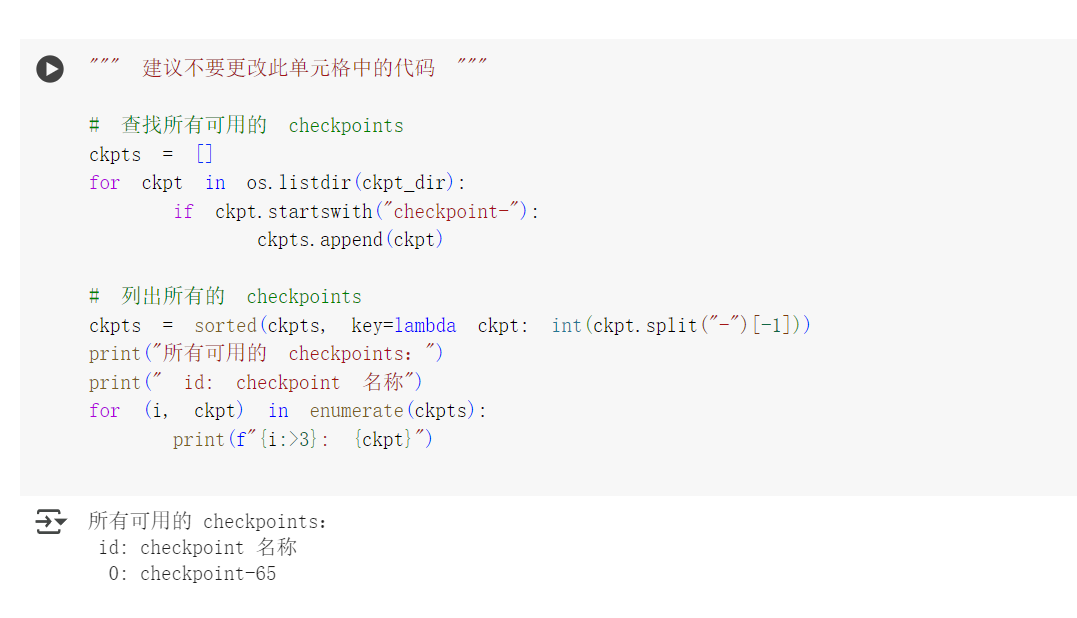
选65是会有对应结果的

In [29]:
f"{2:<3}: {ckpt}" # 右边空格3个

'2  : README.md'

In [19]:
os.listdir(ckpt_dir)

['adapter_config.json', 'adapter_model.safetensors', 'runs', 'README.md']

In [30]:
""" 你可以（但不一定需要）更改 checkpoint """

id_of_ckpt_to_use = -1  # 要用于推理的 checkpoint 的 id（对应上一单元格的输出结果）。
                        # 默认值 -1 表示使用列出的最后一个 checkpoint。
                        # 如果你想选择其他 checkpoint，可以将 -1 更改为列出的 checkpoint id 中的某一个。

# ckpt_name = os.path.join(ckpt_dir, ckpts[id_of_ckpt_to_use])

ckpt_name = os.path.join(ckpt_dir, 'adapter_model.safetensors')

In [22]:
""" 你可以（但不一定需要）更改解码参数 """
# 你可以在此处调整解码参数，解码参数的详细解释请见作业幻灯片。
max_len = 128  # 生成回复的最大长度
temperature = 0.1  # 设置生成回复的随机度，值越小生成的回复越稳定。
top_p = 0.3  # Top-p (nucleus) 采样的概率阈值，用于控制生成回复的多样性。
# top_k = 5  # 调整 Top-k 值，以增加生成回复的多样性并避免生成重复的词汇。

### 释放显存

增加了下面的代码释放之前占用的显存，防止你遇到 OutOfMemoryError。（如果显存足够大可以注释）

In [37]:
import gc

# 删除模型和 tokenizer 对象
del model
del tokenizer

# 调用垃圾回收机制，强制释放未使用的内存
gc.collect()

# 清理 GPU 缓存
torch.cuda.empty_cache()

### 加载模型和分词器

In [38]:


# 配置模型的量化设置，使用 4 位精度
nf4_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=torch.bfloat16
)

# 从预训练模型加载 tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    cache_dir=cache_dir,
    quantization_config=nf4_config
)

# 从预训练模型加载语言模型，使用量化配置并指定设备
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=nf4_config,
    device_map={'': 0},  # 指定使用的设备，GPU 0
    cache_dir=cache_dir
)

# 从 checkpoint 加载已保存的模型权重
model = PeftModel.from_pretrained(model, ckpt_dir, device_map={'': 0})


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [24]:
test_data_path = "GenAI-Hw5/Tang_testing_data.json"  # 测试数据集的路径
output_path = os.path.join(output_dir, "results.txt")  # 生成结果的输出路径

cache_dir = "./cache"  # 设置缓存目录
seed = 42  # 设置随机种子以重现结果
no_repeat_ngram_size = 3  # 设置禁止重复 Ngram 的大小，避免生成重复片段

### 生成测试结果

In [25]:
""" 建议不要更改此单元格中的代码 """
# 这里是用的没有训练的模型 直接全部都输出空格。所以都是原始内容
results = []

# 设置生成配置，包括随机度、束搜索等参数
generation_config = GenerationConfig(
    do_sample=True,
    temperature=temperature,
    num_beams=1,
    top_p=top_p,
    # top_k=top_k,  # 如果需要使用 top-k，可以在此设置
    no_repeat_ngram_size=no_repeat_ngram_size,
    pad_token_id=2
)

# 读取测试数据集
with open(test_data_path, "r", encoding="utf-8") as f:
    test_datas = json.load(f)

# 对每个测试样例生成预测，并保存结果
with open(output_path, "w", encoding="utf-8") as f:
  for (i, test_data) in enumerate(test_datas):
      predict = evaluate(test_data["instruction"], generation_config, max_len, test_data["input"], verbose=False)
      f.write(f"{i+1}. " + test_data["input"] + predict + "\n")
      print(f"{i+1}. " + test_data["input"] + predict)


1. 雪霽銀妝素，桔高映瓊枝。
2. 夫子何爲者？栖栖一代中。
3. 飛蓋去芳園，蘭橈遊翠渚。
4. 條風開獻節，灰律動初陽。
5. 昨夜星辰昨夜風，畫樓西畔桂堂東。
6. 三日入廚下，洗手作羹湯。
7. 嵩雲秦樹久離居，雙鯉迢迢一紙書。
8. 慨然撫長劒，濟世豈邀名。
9. 乘興南遊不戒嚴，九重誰省諫書函。
10. 猿鳥猶疑畏簡書，風雲常爲護儲胥。
11. 君問歸期未有期，巴山夜雨漲秋池。
12. 相見時難別亦難，東風無力百花殘。
13. 雲母屏風燭影深，長河漸落曉星沈。
14. 高閣客竟去，小園花亂飛。
15. 瑤池阿母綺窗開，黃竹歌聲動地哀。


In [39]:
""" 建议不要更改此单元格中的代码 """

results = []

# 设置生成配置，包括随机度、束搜索等参数
generation_config = GenerationConfig(
    do_sample=True,
    temperature=temperature,
    num_beams=1,
    top_p=top_p,
    # top_k=top_k,  # 如果需要使用 top-k，可以在此设置
    no_repeat_ngram_size=no_repeat_ngram_size,
    pad_token_id=2
)

# 读取测试数据集
with open(test_data_path, "r", encoding="utf-8") as f:
    test_datas = json.load(f)

# 对每个测试样例生成预测，并保存结果
with open(output_path, "w", encoding="utf-8") as f:
  for (i, test_data) in enumerate(test_datas):
      predict = evaluate(test_data["instruction"], generation_config, max_len, test_data["input"], verbose=False)
      f.write(f"{i+1}. " + test_data["input"] + predict + "\n")
      print(f"{i+1}. " + test_data["input"] + predict)


1. 雪霽銀妝素，桔高映瓊枝。春色未相及，花落未相聞。
2. 夫子何爲者？栖栖一代中。不言有道者，無道有道人。
3. 飛蓋去芳園，蘭橈遊翠渚。春色未相及，秋風已相知。
4. 條風開獻節，灰律動初陽。春草新綠草，春花新紅花。
5. 昨夜星辰昨夜風，畫樓西畔桂堂東。玉葉垂葉綠，金花落花紅。
6. 三日入廚下，洗手作羹湯。一壺酒未飲，一壺水未倒。
7. 嵩雲秦樹久離居，雙鯉迢迢一紙書。年年春色不相待，日暮秋風更相追。
8. 慨然撫長劒，濟世豈邀名。不欲終年客，唯願終年行。
9. 乘興南遊不戒嚴，九重誰省諫書函。春色未盡秋色新，花落葉落心不空。
10. 猿鳥猶疑畏簡書，風雲常爲護儲胥。玉樹春色滿園裏，金屋秋風入樓中。
11. 君問歸期未有期，巴山夜雨漲秋池。月明空庭無人語，風動孤樹無人聲。
12. 相見時難別亦難，東風無力百花殘。春光已過春草盡，秋風起時秋葉空。
13. 雲母屏風燭影深，長河漸落曉星沈。玉樓秋風起，金殿春雨生。
14. 高閣客竟去，小園花亂飛。春色不相待，秋風更相憐。
15. 瑤池阿母綺窗開，黃竹歌聲動地哀。玉葉垂垂春色新，金花落落春色深。


## 查看微调后的模型与微调前的对比

我们现在检查微调后的模型在之前看到的例子上的表现。

In [27]:
# 使用之前的测试例子
test_tang_list = [
    '相見時難別亦難，東風無力百花殘。',
    '重帷深下莫愁堂，臥後清宵細細長。',
    '芳辰追逸趣，禁苑信多奇。'
]

# 使用微调后的模型进行推理
demo_after_finetune = []
for tang in test_tang_list:
    demo_after_finetune.append(
        f'模型輸入:\n以下是一首唐詩的第一句話，請用你的知識判斷並完成整首詩。{tang}\n\n模型輸出:\n' +
        evaluate('以下是一首唐詩的第一句話，請用你的知識判斷並完成整首詩。', generation_config, max_len, tang, verbose=False)
    )

# 打印输出结果
for idx in range(len(demo_after_finetune)):
    print(f"Example {idx + 1}:")
    print(demo_after_finetune[idx])
    print("-" * 80)

Example 1:
模型輸入:
以下是一首唐詩的第一句話，請用你的知識判斷並完成整首詩。相見時難別亦難，東風無力百花殘。

模型輸出:

--------------------------------------------------------------------------------
Example 2:
模型輸入:
以下是一首唐詩的第一句話，請用你的知識判斷並完成整首詩。重帷深下莫愁堂，臥後清宵細細長。

模型輸出:

--------------------------------------------------------------------------------
Example 3:
模型輸入:
以下是一首唐詩的第一句話，請用你的知識判斷並完成整首詩。芳辰追逸趣，禁苑信多奇。

模型輸出:

--------------------------------------------------------------------------------


In [40]:
# 使用之前的测试例子
test_tang_list = [
    '相見時難別亦難，東風無力百花殘。',
    '重帷深下莫愁堂，臥後清宵細細長。',
    '芳辰追逸趣，禁苑信多奇。'
]

# 使用微调后的模型进行推理
demo_after_finetune = []
for tang in test_tang_list:
    demo_after_finetune.append(
        f'模型輸入:\n以下是一首唐詩的第一句話，請用你的知識判斷並完成整首詩。{tang}\n\n模型輸出:\n' +
        evaluate('以下是一首唐詩的第一句話，請用你的知識判斷並完成整首詩。', generation_config, max_len, tang, verbose=False)
    )

# 打印输出结果
for idx in range(len(demo_after_finetune)):
    print(f"Example {idx + 1}:")
    print(demo_after_finetune[idx])
    print("-" * 80)

Example 1:
模型輸入:
以下是一首唐詩的第一句話，請用你的知識判斷並完成整首詩。相見時難別亦難，東風無力百花殘。

模型輸出:
春光已過春草盡，秋風起時秋葉空。
--------------------------------------------------------------------------------
Example 2:
模型輸入:
以下是一首唐詩的第一句話，請用你的知識判斷並完成整首詩。重帷深下莫愁堂，臥後清宵細細長。

模型輸出:
月明玉樓照人面，風動金樹動花香。
--------------------------------------------------------------------------------
Example 3:
模型輸入:
以下是一首唐詩的第一句話，請用你的知識判斷並完成整首詩。芳辰追逸趣，禁苑信多奇。

模型輸出:
春草初生時，花木正初開。
--------------------------------------------------------------------------------


## 参考链接

[唐诗数据集](https://github.com/chinese-poetry/chinese-poetry/tree/master/%E5%85%A8%E5%94%90%E8%AF%97?fbclid=IwAR2bM14S42T-VtrvMi3wywCqKfYJraBtMl7QVTo0qyPMjX9jj9Vj3JepFBA)